In [1]:
# Python Notebook for Adversarial Patch Attack

import os
import hydra
import torch
from omegaconf import OmegaConf
import pathlib
from torch.utils.data import DataLoader
import copy
import random
import dill
import wandb
import tqdm
import numpy as np
import shutil
import collections
from diffusion_policy.workspace.base_workspace import BaseWorkspace
from diffusion_policy.policy.robomimic_image_policy import RobomimicImagePolicy
from diffusion_policy.dataset.base_dataset import BaseImageDataset
from diffusion_policy.dataset.robomimic_replay_image_dataset import RobomimicReplayImageDataset
from diffusion_policy.env_runner.base_image_runner import BaseImageRunner
from diffusion_policy.common.checkpoint_util import TopKCheckpointManager
from diffusion_policy.common.json_logger import JsonLogger
from diffusion_policy.common.pytorch_util import dict_apply, optimizer_to
from diffusion_policy.workspace.train_robomimic_image_workspace import TrainRobomimicImageWorkspace
from diffusion_policy.utils.attack_utils import transform_square_patch

/home/zeus/miniconda3/envs/cloudspace/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import robomimic.utils.env_utils as EnvUtils
import robomimic.utils.obs_utils as ObsUtils
import robomimic.utils.file_utils as FileUtils

def create_env(env_meta, shape_meta, enable_render=True):
    modality_mapping = collections.defaultdict(list)
    for key, attr in shape_meta['obs'].items():
        modality_mapping[attr.get('type', 'low_dim')].append(key)
    ObsUtils.initialize_obs_modality_mapping_from_dict(modality_mapping)
    print(env_meta)

    env = EnvUtils.create_env_from_metadata(
        env_meta=env_meta,
        render=False, 
        render_offscreen=enable_render,
        use_image_obs=enable_render, 
    )
    return env

In [3]:
checkpoint = '/teamspace/studios/this_studio/bc_attacks/diffusion_policy/data/experiments/image/lift_ph/vanilla_bc/train_0/checkpoints/epoch=0500-test_mean_score=1.000.ckpt'
payload = torch.load(open(checkpoint, 'rb'), pickle_module=dill)
cfg_loaded = payload['cfg']
cls = hydra.utils.get_class(cfg_loaded._target_)
workspace = cls(cfg_loaded)
workspace.load_payload(payload, exclude_keys=None, include_keys=None)
policy = workspace.model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy.to(device)
policy.eval()

cfg_loaded.task.env_runner['_target_'] = 'diffusion_policy.env_runner.robomimic_single_image_runner.RobomimicSingleImageRunner'
cfg_loaded.task.env_runner.dataset_path = os.path.join('/teamspace/studios/this_studio/bc_attacks/diffusion_policy', cfg_loaded.task.dataset_path)
env_runner = hydra.utils.instantiate(
    cfg_loaded.task.env_runner,
    output_dir=None
)
env = env_runner.env



============= Initialized Observation Utils with Obs Spec =============

using obs modality: low_dim with keys: ['robot0_eef_quat', 'robot0_eef_pos', 'robot0_gripper_qpos']
using obs modality: rgb with keys: ['robot0_eye_in_hand_image', 'agentview_image']
using obs modality: depth with keys: []
using obs modality: scan with keys: []


/home/zeus/miniconda3/envs/cloudspace/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


{'env_name': 'Lift', 'type': 1, 'env_kwargs': {'has_renderer': False, 'has_offscreen_renderer': True, 'ignore_done': True, 'use_object_obs': False, 'use_camera_obs': True, 'control_freq': 20, 'controller_configs': {'type': 'OSC_POSE', 'input_max': 1, 'input_min': -1, 'output_max': [0.05, 0.05, 0.05, 0.5, 0.5, 0.5], 'output_min': [-0.05, -0.05, -0.05, -0.5, -0.5, -0.5], 'kp': 150, 'damping': 1, 'impedance_mode': 'fixed', 'kp_limits': [0, 300], 'damping_limits': [0, 10], 'position_limits': None, 'orientation_limits': None, 'uncouple_pos_ori': True, 'control_delta': True, 'interpolation': None, 'ramp_ratio': 0.2}, 'robots': ['Panda'], 'camera_depths': False, 'camera_heights': 84, 'camera_widths': 84, 'reward_shaping': False, 'camera_names': ['agentview', 'robot0_eye_in_hand'], 'render_gpu_device_id': 0}}
Created environment with name Lift
Action size is 7


In [4]:
# collect observations and actions for the policy for one rollout
import tqdm
obs = env.reset()
obs_list = []
action_list = []
done = False
timestep = 0
max_timesteps = 100
for i in range(10):
    with tqdm.tqdm(total=max_timesteps, desc="Timesteps") as pbar:
        timestep = 0
        while not done and timestep < max_timesteps:
            np_obs_dict = dict(obs)
            obs_dict = dict_apply(np_obs_dict, lambda x: torch.tensor(x).unsqueeze(0).to(device))
            obs_list.append(obs_dict)
            action_dict = policy.predict_action(obs_dict)
            np_action_dict = dict_apply(action_dict, lambda x: x.cpu().detach().numpy())
            action = np_action_dict['action'].squeeze(0)        
            obs, _, done, _ = env.step(action)
            action_list.append(action)
            
            timestep += 1
            pbar.update(1)


Timesteps:   0%|          | 0/100 [00:00<?, ?it/s]


In [5]:
# squeeze the obs to shape (3, size, size)
obs_list = [dict_apply(obs, lambda x: x.squeeze(0)) for obs in obs_list]
# save the obs_list to load next time

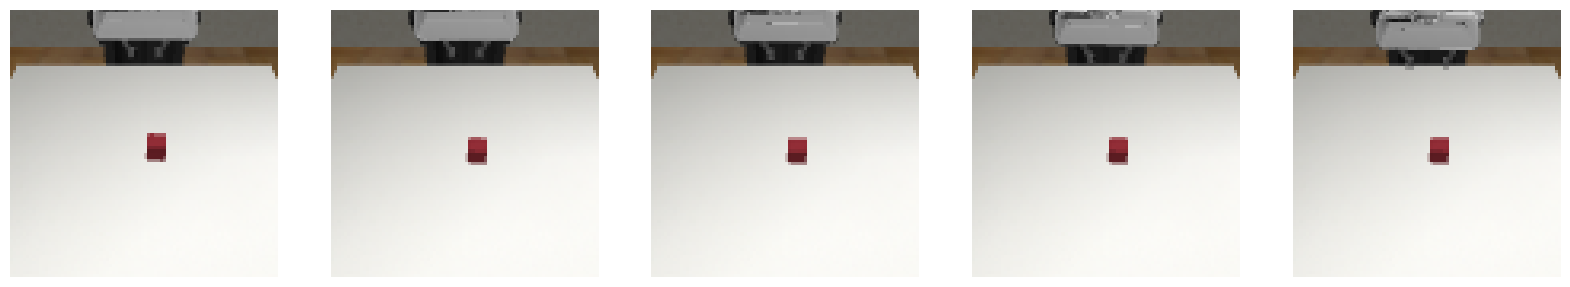

In [6]:
# visualize few of the agentview_image observations
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    obs = obs_list[i]
    agentview_image = obs['agentview_image'].squeeze(0).cpu().detach().numpy()
    agentview_image = np.transpose(agentview_image, (1, 2, 0))
    axes[i].imshow(agentview_image)
    axes[i].axis('off')
plt.show()


In [19]:
# add perturbations to the actions
perturbations = np.array([0.30, 0.30, 0., 0, 0, 0, 0])
target_action_list = []
for i in range(len(action_list)):
    target_action = action_list[i] + perturbations
    # target action to close the gripper always
    # target_action[-1] = 1
    target_action_list.append(target_action)


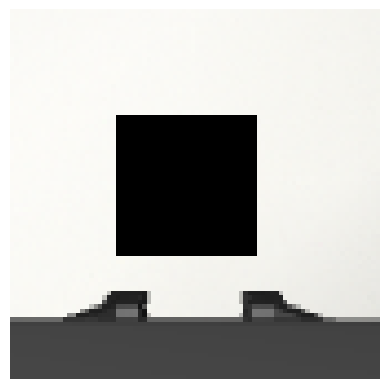

In [21]:
def place_patch(image, patch, location=(0, 0)):
    # image: (B, n_obs, 3, size, size)
    # patch: (3, patch_size, patch_size)
    # location: (x, y)
    original_len = len(image.shape)
    if original_len == 4:
        image = image.unsqueeze(0)
    x, y = location
    image[:, :, :, x:x+patch.shape[1], y:y+patch.shape[2]] = patch_forward(patch)
    if original_len == 4:
        image = image.squeeze(0)
    return image

def patch_forward(patch):
    # applies tanh to the patch and scales it to [0, 1]
    # patch = torch.tanh(patch) / 2 + 0.5
    patch = 0.125 * torch.tanh(patch)
    return patch

def place_transparent_patch(image, patch, location=(0, 0)):
    # image: (B, n_obs, 3, size, size)
    # patch: (3, patch_size, patch_size)
    # location: (x, y)
    original_len = len(image.shape)
    if original_len == 4:
        image = image.unsqueeze(0)
    x, y = location
    patch = patch_forward(patch)
    # image[:, :, :, x:x+patch.shape[1], y:y+patch.shape[2]] = patch_alpha * patch[:3] + (1 - patch_alpha) * image[:, :, :, x:x+patch.shape[1], y:y+patch.shape[2]]
    image[:, :, :, :, :] = image[:, :, :, :, :] + patch[:3]
    if original_len == 4:
        image = image.squeeze(0)
    return image

# visualize the patch
patch_ = torch.zeros((3, 32, 32))
image_ = obs_list[0]['robot0_eye_in_hand_image'].clone()
image_ = place_patch(image_, patch_, location=(24, 24))
image_ = image_.squeeze(0).cpu().detach().numpy()
image_ = np.transpose(image_, (1, 2, 0))
plt.imshow(image_)
plt.axis('off')
plt.show()

In [16]:
x_loc, y_loc = 16, 16
patch_size = 16

In [17]:
# evaluate the patch
view = 'robot0_eye_in_hand_image'
# view = 'agentview_image'
def evaluate_patch(patch, transparent=False):
    patch_cp = patch.clone().detach()
    obs = env.reset()
    policy.reset()
    obs = dict_apply(obs, lambda x: torch.tensor(x).to(device))
    if transparent:
        obs[view] = place_transparent_patch(obs[view], patch_cp, location=(0, 0))
    else:
        obs[view] = place_patch(obs[view], patch_cp, location=(x_loc, y_loc))
    # convert to tensor
    obs = dict_apply(obs, lambda x: torch.tensor(x).unsqueeze(0))
    done = False
    max_timesteps = 400
    rewards = 0
    obs_agentview = []
    obs_robot0_eye_in_hand = []
    with tqdm.tqdm(total=max_timesteps, desc="Timesteps") as pbar:
        timestep = 0
        while not done and timestep < max_timesteps:
            # for key in obs.keys():
            #    print(key, obs[key].shape)
            action_dict = policy.predict_action(obs)
            action = action_dict['action'].cpu().detach().numpy().squeeze(0)
            obs, reward, done, _ = env.step(action)
            obs = dict_apply(obs, lambda x: torch.tensor(x).to(device))
            if transparent:
                obs[view] = place_transparent_patch(obs[view], patch_cp, location=(0, 0))
            else:
                obs[view] = place_patch(obs[view], patch_cp, location=(x_loc, y_loc))
            # obs = dict_apply(obs, lambda x: x.squeeze(0))
            obs = dict_apply(obs, lambda x: torch.tensor(x).unsqueeze(0))
            obs_agentview.append(obs['agentview_image'])
            obs_robot0_eye_in_hand.append(obs['robot0_eye_in_hand_image'])
            timestep += 1
            pbar.update(1)
            rewards += reward
        if rewards > 0:
            print(f"Patch is unsuccessful with reward: {rewards}")
        elif rewards == 0:
            print(f"Patch is successful with reward: {rewards}")
        else:
            pass
    return rewards, obs_agentview, obs_robot0_eye_in_hand

# test the evaluate_patch function
# patch = torch.zeros((3, patch_size, patch_size))
# red_patch = torch.zeros((3, patch_size, patch_size))
# red_patch[0] = 1
# rewards, observation_agentview, observation_robot0_eye_in_hand = evaluate_patch(red_patch)
# print(rewards)

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from matplotlib.animation import FuncAnimation, ArtistAnimation


def visualize(observations1, observations2, file_name, every_frame=2):
    # only get alternate frames to reduce the processing time
    observations1 = observations1[::every_frame]
    observations2 = observations2[::every_frame]
    im = []
    for i in range(len(observations1)):
        agentview_image1 = observations1[i].squeeze(0).squeeze(0).cpu().detach().numpy()
        agentview_image1 = np.transpose(agentview_image1, (1, 2, 0))
        
        agentview_image2 = observations2[i].squeeze(0).squeeze(0).cpu().detach().numpy()
        agentview_image2 = np.transpose(agentview_image2, (1, 2, 0))
        
        combined_image = np.hstack((agentview_image1, agentview_image2))
        im.append(combined_image)

    fig, ax = plt.subplots()
    ims = []
    for i in range(len(im)):
        im_obj = ax.imshow(im[i], animated=True)
        ims.append([im_obj])
        ax.axis('off')

    ani = ArtistAnimation(fig, ims, interval=100, blit=True)
    ani.save(file_name, writer='pillow', fps=10)

# visualize the observations
# visualize(observation_robot0_eye_in_hand, observation_agentview, file_name = f'/teamspace/studios/this_studio/bc_attacks/diffusion_policy/plots/videos/adversarial_patch/red_patch_x_{x_loc}_y_{y_loc}_{patch_size}_rew_{rewards}.gif')


In [10]:
from torch.utils.data import Dataset
class ObservationActionDataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = observations
        self.actions = actions

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

In [27]:
# disable cudann
torch.backends.cudnn.enabled = False
# create a patch of size 24x24
def patch_attack(policy, train_loader, val_loader, patch_size, num_iterations=100):
    # create a patch of size 24x24
    patch = torch.zeros((3, patch_size, patch_size), dtype=torch.float32)
    clean_patch = patch.clone().detach().to(device)
    patch = patch.to(device)
    # convert the patch to a parameter which can be optimized
    patch = torch.nn.Parameter(patch)
    optimizer = torch.optim.Adam([patch], lr=0.01)
    losses = []
    with tqdm.tqdm(total=num_iterations, desc="Iterations") as pbar:
        for i in range(num_iterations):
            total_loss = 0
            for obs, target_action in train_loader:
                policy.reset()
                obs[view] = place_patch(obs[view], patch, location=(x_loc, y_loc))
                actions = policy.predict_action(obs)['action']
                loss = torch.nn.functional.mse_loss(action_means, torch.tensor(target_action, dtype=torch.float32).to(device))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            losses.append(total_loss)
            # print(f"Change in patch: {torch.norm(patch - clean_patch)}")
            if i % 100 == 0 and i != 0:
                print(f"Iteration: {i}, Loss: {total_loss}")
                # evaluate_patch(patch)
                # visualize the patch
                patch_np = patch.cpu().detach().numpy()
                patch_np = np.transpose(patch_np, (1, 2, 0))
                plt.imshow(patch_np)
                plt.axis('off')
                plt.show()
            pbar.update(1)
    # plot the losses
    plt.plot(losses)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Loss vs Iterations')
    plt.show()
    return patch

# convert the obs_list and target_action_list to tensors as a dataset
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
# Split data into training and validation sets
obs_train, obs_val, action_train, action_val = train_test_split(obs_list, target_action_list, test_size=0.2, random_state=42)
# Create Dataset instances
train_dataset = ObservationActionDataset(obs_train, action_train)
val_dataset = ObservationActionDataset(obs_val, action_val)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# patch_sizes = [20, 24, 28, 32]
patch_sizes = [24]
for patch_size in patch_sizes:
    patch = patch_attack(policy, train_loader, val_loader, patch_size, num_iterations=200)
    # evaluate the patch
    rewards, observation_patch_agentview, observation_patch_robot0 = evaluate_patch(patch)
    print(f"Reward: {rewards}")
    # visualize the observations
    file_name = f'/teamspace/studios/this_studio/bc_attacks/diffusion_policy/plots/videos/adversarial_patch/trained_patch_perturbed_y15_x_{x_loc}_y_{y_loc}_{patch_size}_rew_{rewards}.gif'
    visualize(observation_patch_robot0, observation_patch_agentview, file_name = file_name)


Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Iterations:   0%|          | 0/200 [00:00<?, ?it/s]


NameError: name 'action_means' is not defined

Iterations:   0%|          | 0/400 [00:00<?, ?it/s]/tmp/ipykernel_7303/2105181730.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.functional.mse_loss(actions, torch.tensor(target_action, dtype=torch.float32).to(device))
Iterations:  25%|██▌       | 100/400 [01:07<03:23,  1.48it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration: 100, Loss: 0.17718549724668264


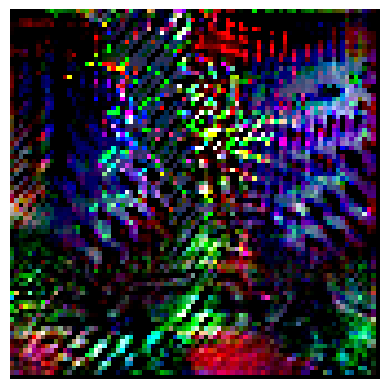

Iterations:  33%|███▎      | 133/400 [01:29<03:03,  1.46it/s]

In [23]:
# disable cudann
x_loc_trans, y_loc_trans = 0, 0
torch.backends.cudnn.enabled = False
epsilon = 0.125
# create a patch of size 24x24
def patch_attack(policy, train_loader, val_loader, patch_size, num_iterations=100):
    # create a universal patch of size 84x84
    universal_patch = torch.zeros((3, patch_size, patch_size), dtype=torch.float32)
    # clean_patch = patch.clone().detach().to(device)
    # patch = patch.to(device)
    # convert the patch to a parameter which can be optimized
    # patch = torch.nn.Parameter(patch)
    universal_patch = universal_patch.to(device)
    # convert the patch to a parameter which can be optimized
    universal_patch = torch.nn.Parameter(universal_patch)
    optimizer = torch.optim.Adam([universal_patch], lr=0.005)
    losses = []
    with tqdm.tqdm(total=num_iterations, desc="Iterations") as pbar:
        for i in range(num_iterations):
            total_loss = 0
            for obs, target_action in train_loader:
                policy.reset()
                obs[view] = place_transparent_patch(obs[view], universal_patch, location=(x_loc_trans, y_loc_trans))
                obs[view] = torch.clamp(obs[view], 0, 1)
                actions = policy.predict_action(obs)['action']
                loss = torch.nn.functional.mse_loss(actions, torch.tensor(target_action, dtype=torch.float32).to(device))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                # clip the universal patch to be within the epsilon ball
                # with torch.no_grad():
                #    universal_patch = torch.clamp(universal_patch, -epsilon, epsilon)
                # clip the observation to be within [0, 1]
                total_loss += loss.item()
            losses.append(total_loss)
            # print(universal_patch.min(), universal_patch.max())
            # print(f"Change in patch: {torch.norm(patch - clean_patch)}")
            if i % 100 == 0 and i != 0:
                print(f"Iteration: {i}, Loss: {total_loss}")
                # evaluate_patch(patch)
                # visualize the patch
                patch_np = universal_patch.cpu().detach().numpy()
                patch_np = np.transpose(patch_np, (1, 2, 0))
                plt.imshow(patch_np)
                plt.axis('off')
                plt.show()
            pbar.update(1)
    # plot the losses
    plt.plot(losses)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Loss vs Iterations')
    plt.show()
    return universal_patch

# convert the obs_list and target_action_list to tensors as a dataset
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
# Split data into training and validation sets
obs_train, obs_val, action_train, action_val = train_test_split(obs_list, target_action_list, test_size=0.2, random_state=42)
# Create Dataset instances
train_dataset = ObservationActionDataset(obs_train, action_train)
val_dataset = ObservationActionDataset(obs_val, action_val)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# patch_sizes = [20, 24, 28, 32]
patch_sizes = [84]
for patch_size in patch_sizes:
    universal_patch = patch_attack(policy, train_loader, val_loader, patch_size, num_iterations=400)
    print(universal_patch.min(), universal_patch.max())
    # save the universal_patch as a numpy file
    universal_patch_np = universal_patch.cpu().detach().numpy()
    np.save(f'/teamspace/studios/this_studio/bc_attacks/diffusion_policy/plots/universal_patch/vanilla_bc_universal_patch_transparent_xy_30_400iters_eps_0.125.npy', universal_patch_np)
    # evaluate the patch
    rewards, observation_patch_agentview, observation_patch_robot0 = evaluate_patch(universal_patch, transparent=True)
    print(f"Reward: {rewards}")
    # visualize the observations
    file_name = f'/teamspace/studios/this_studio/bc_attacks/diffusion_policy/plots/videos/adversarial_patch/vanilla_bc_trained_transparent_patch_perturbed_x_30_y30_rew_{rewards}_eps0.125.gif'
    visualize(observation_patch_robot0, observation_patch_agentview, file_name = file_name)



============= Initialized Observation Utils with Obs Spec =============

using obs modality: low_dim with keys: ['robot0_gripper_qpos', 'robot0_eef_quat', 'robot0_eef_pos']
using obs modality: rgb with keys: ['agentview_image', 'robot0_eye_in_hand_image']
using obs modality: depth with keys: []
using obs modality: scan with keys: []


/home/zeus/miniconda3/envs/cloudspace/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_5782/3492069373.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = dict_apply(obs, lambda x: torch.tensor(x).unsqueeze(0))
Timesteps:   0%|          | 0/400 [00:00<?, ?it/s]/tmp/ipykernel_5782/3492069373.py:34: UserWarning: To copy construct from a tensor, it is recommended

Patch is successful with reward: 0.0
Reward: 0.0


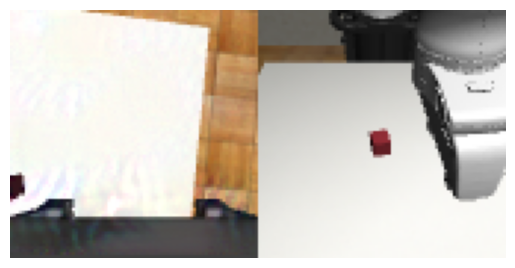

In [28]:
# load other checkpoints policy to check the performance of the patch
checkpoint = '/teamspace/studios/this_studio/bc_attacks/diffusion_policy/data/experiments/image/lift_ph/vanilla_bc/train_0/checkpoints/epoch=0500-test_mean_score=1.000.ckpt'
payload = torch.load(open(checkpoint, 'rb'), pickle_module=dill)
cfg_loaded = payload['cfg']
cls = hydra.utils.get_class(cfg_loaded._target_)
workspace = cls(cfg_loaded)
workspace.load_payload(payload, exclude_keys=None, include_keys=None)
policy = workspace.model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy.to(device)
policy.eval()

# evaluate the patch
rewards, observation_patch_agentview, observation_patch_robot0 = evaluate_patch(universal_patch, transparent=True)
print(f"Reward: {rewards}")
# visualize the observations
file_name = f'/teamspace/studios/this_studio/bc_attacks/diffusion_policy/plots/videos/adversarial_patch/vanilla_bc_trained0_transparent_patch_perturbed_y15_rew_{rewards}.gif'
visualize(observation_patch_robot0, observation_patch_agentview, file_name = file_name)


In [48]:
print(universal_patch.min(), universal_patch.max())

tensor(-3.0544, device='cuda:0', grad_fn=<MinBackward1>) tensor(2.9877, device='cuda:0', grad_fn=<MaxBackward1>)


/tmp/ipykernel_31751/878138627.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = dict_apply(obs, lambda x: torch.tensor(x).unsqueeze(0))
Timesteps:   0%|          | 0/400 [00:00<?, ?it/s]/tmp/ipykernel_31751/878138627.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = dict_apply(obs, lambda x: torch.tensor(x).unsqueeze(0))
Timesteps: 100%|██████████| 400/400 [00:53<00:00,  7.46it/s]


Patch is successful with reward: 0.0
Reward: 0.0


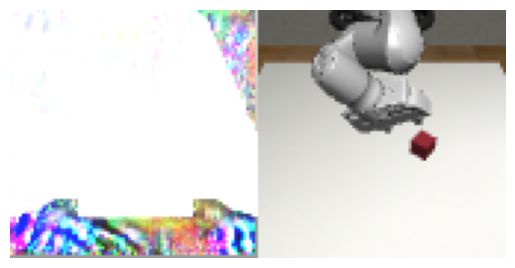

In [45]:
patch_size = 84
rewards, observation_patch_agentview, observation_patch_robot0 = evaluate_patch(universal_patch, transparent=True)
print(f"Reward: {rewards}")
# visualize the observations
file_name = f'/teamspace/studios/this_studio/bc_attacks/diffusion_policy/plots/videos/adversarial_patch/trained_transparent_patch_perturbed_y60_x_{x_loc_trans}_y_{y_loc_trans}_{patch_size}_rew_{rewards}.gif'
visualize(observation_patch_robot0, observation_patch_agentview, file_name = file_name)


In [31]:
# visualize how the patch looks like on the robot0_eye_in_hand_image
obs_robot0 = obs_list[0]
obs_robot0 = place_patch(obs_robot0, patch, location=(16, 16))
obs_robot0 = obs_robot0.squeeze(0).squeeze(0).cpu().detach().numpy()
obs_robot0 = np.transpose(obs_robot0, (1, 2, 0))
plt.imshow(obs_robot0)
plt.axis('off')
plt.show()


AttributeError: 'dict' object has no attribute 'shape'